# Florence-2-large sample usage

In [2]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [3]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

c:\Users\stopc\anaconda3\envs\transformers-env\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## define the prediction function

In [4]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    return parsed_answer

## init image

In [5]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

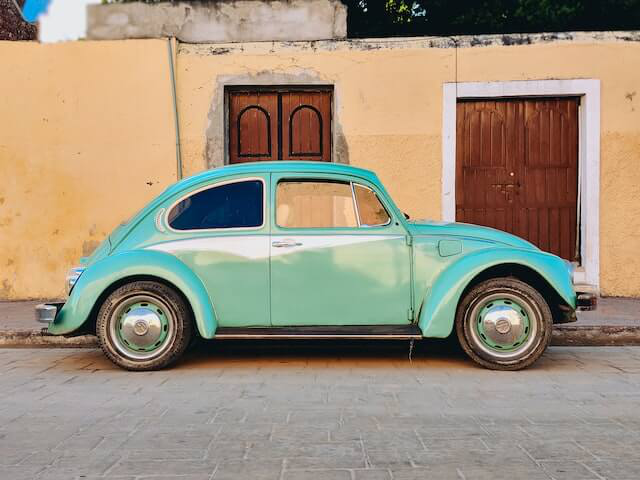

In [6]:
image

## Run pre-defined tasks without additional inputs

### Caption

In [7]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'A green car parked in front of a yellow building.'}

In [8]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [9]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. It has two doors on either side of the car, one with a brown door and the other with a white door. The building appears to be old and dilapidated, with peeling paint and crumbling walls. The sky is blue and there are trees in the background.'}

### Object detection

OD results format:
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...],
    'labels': ['label1', 'label2', ...]
    }
}

In [10]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812], [452.1600036621094, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'door handle', 'wheel', 'wheel']}}


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

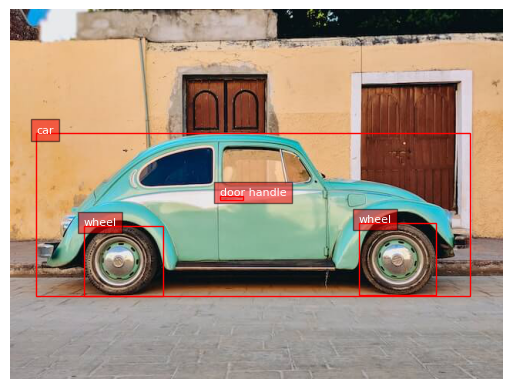

In [12]:
plot_bbox(image, results['<OD>'])

### Dense region caption

Dense region caption results format:
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [13]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [452.1600036621094, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812]], 'labels': ['turquoise Volkswagen Beetle', 'wheel', 'wheel', 'door handle']}}


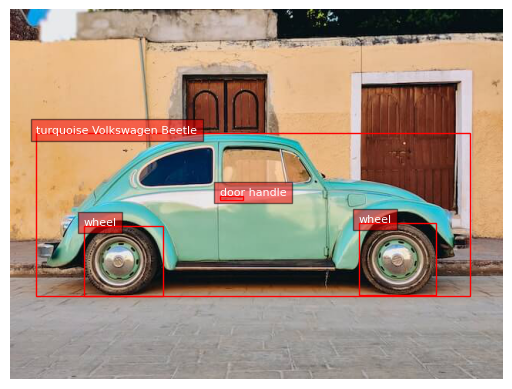

In [14]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format:
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [15]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094, 160.0800018310547, 596.7999877929688, 371.7599792480469], [454.7200012207031, 97.19999694824219, 579.5199584960938, 261.8399963378906], [450.8800048828125, 276.7200012207031, 553.2799682617188, 370.79998779296875], [95.04000091552734, 280.55999755859375, 198.0800018310547, 371.2799987792969], [226.87998962402344, 89.04000091552734, 332.47998046875, 164.39999389648438], [66.23999786376953, 266.6399841308594, 86.72000122070312, 295.91998291015625], [271.67999267578125, 241.67999267578125, 302.3999938964844, 246.95999145507812], [408.0, 308.3999938964844, 413.7599792480469, 320.8800048828125], [509.1199951171875, 172.0800018310547, 514.8800048828125, 176.39999389648438]], 'labels': ['', '', '', '', '', '', '', '', '']}}


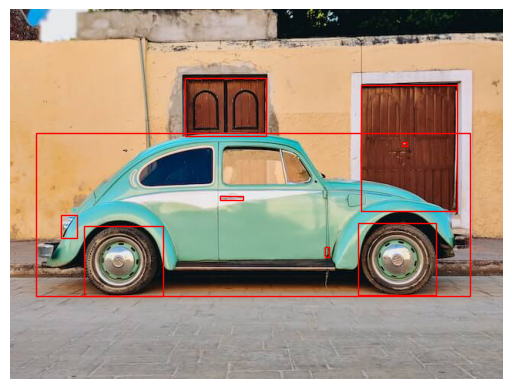

In [16]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs

### Phrase Grounding
Phrase grounding results format:
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [49]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 159.1199951171875, 582.0800170898438, 374.6399841308594], [1.5999999046325684, 4.559999942779541, 638.3999633789062, 304.55999755859375]], 'labels': ['A green car', 'a yellow building']}}


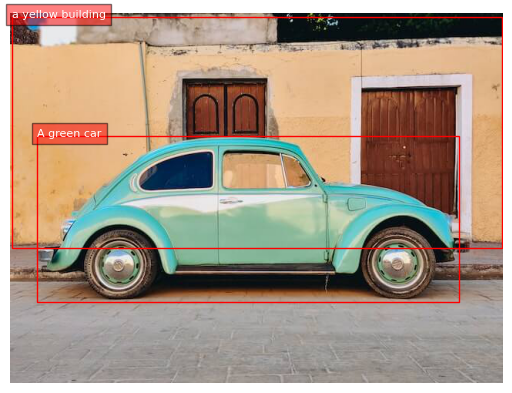

In [50]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format:
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [19]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<REFERRING_EXPRESSION_SEGMENTATION>': {'polygons': [[[178.87998962402344, 181.1999969482422, 180.8000030517578, 180.239990234375, 182.72000122070312, 180.239990234375, 187.83999633789062, 176.87998962402344, 189.75999450683594, 176.87998962402344, 192.95999145507812, 174.95999145507812, 194.87998962402344, 174.95999145507812, 198.0800018310547, 173.0399932861328, 200.63999938964844, 172.0800018310547, 203.83999633789062, 171.1199951171875, 207.0399932861328, 170.16000366210938, 210.239990234375, 169.1999969482422, 214.0800018310547, 168.239990234375, 217.9199981689453, 166.8000030517578, 221.75999450683594, 165.83999633789062, 226.239990234375, 164.87998962402344, 230.72000122070312, 163.9199981689453, 237.1199951171875, 162.95999145507812, 244.79998779296875, 162.0, 255.0399932861328, 161.0399932861328, 272.32000732421875, 160.0800018310547, 308.1600036621094, 160.0800018310547, 326.0799865722656, 161.0399932861328, 335.03997802734375, 162.0, 342.0799865722656, 162.95999145507812, 3

In [20]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):
    """
    Draws segmentation masks with polygons on an image.

    Parameters:
    - image_path: Path to the image file.
    - prediction: Dictionary containing 'polygons' and 'labels' keys.
                  'polygons' is a list of lists, each containing vertices of a polygon.
                  'labels' is a list of labels corresponding to each polygon.
    - fill_mask: Boolean indicating whether to fill the polygons with color.
    """
    # Load the image

    draw = ImageDraw.Draw(image)


    # Set up scale factor if needed (use 1 if not scaling)
    scale = 1

    # Iterate over polygons and labels
    for polygons, label in zip(prediction['polygons'], prediction['labels']):
        color = random.choice(colormap)
        fill_color = random.choice(colormap) if fill_mask else None

        for _polygon in polygons:
            _polygon = np.array(_polygon).reshape(-1, 2)
            if len(_polygon) < 3:
                print('Invalid polygon:', _polygon)
                continue

            _polygon = (_polygon * scale).reshape(-1).tolist()

            # Draw the polygon
            if fill_mask:
                draw.polygon(_polygon, outline=color, fill=fill_color)
            else:
                draw.polygon(_polygon, outline=color)

            # Draw the label text
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)

    # Save or display the image
    #image.show()  # Display the image
    display(image)

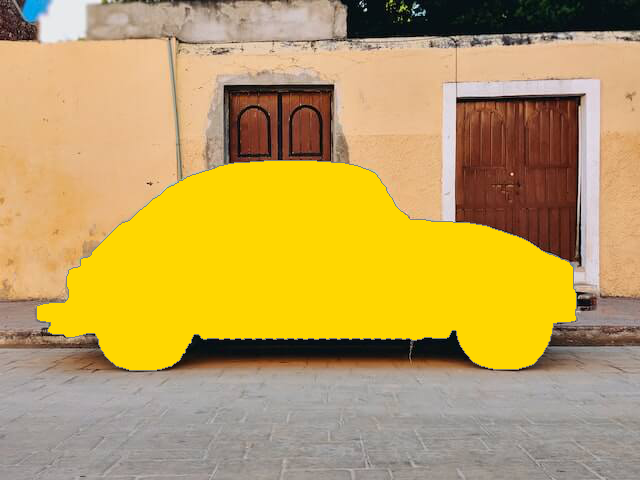

In [21]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999].

In [22]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[470.7200012207031, 287.2799987792969, 473.91998291015625, 284.8800048828125, 477.1199951171875, 282.9599914550781, 479.03997802734375, 282.0, 480.9599914550781, 282.0, 484.1600036621094, 280.0799865722656, 486.7200012207031, 279.1199951171875, 489.91998291015625, 278.1600036621094, 495.03997802734375, 277.1999816894531, 512.9599609375, 277.1999816894531, 516.1599731445312, 278.1600036621094, 519.3599853515625, 280.0799865722656, 520.6400146484375, 280.0799865722656, 525.1199951171875, 282.0, 527.0399780273438, 283.91998291015625, 530.239990234375, 284.8800048828125, 534.0800170898438, 288.239990234375, 541.1199951171875, 294.9599914550781, 544.3200073242188, 299.2799987792969, 546.239990234375, 302.1600036621094, 548.1599731445312, 305.03997802734375, 548.7999877929688, 306.9599914550781, 550.0800170898438, 309.8399963378906, 550.719970703125, 312.7200012207031, 552.0, 317.03997802734375, 552.0, 333.8399963378906, 550.719970703125, 338.16000

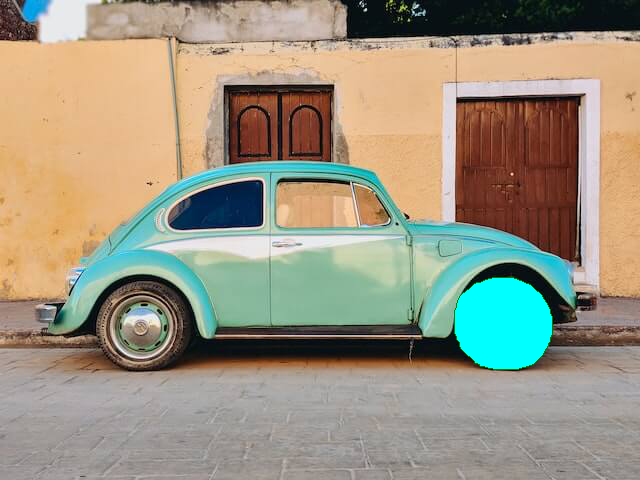

In [23]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts.

results format:

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [59]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.23999786376953, 158.63999938964844, 581.4400024414062, 374.1600036621094]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [56]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

In [60]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

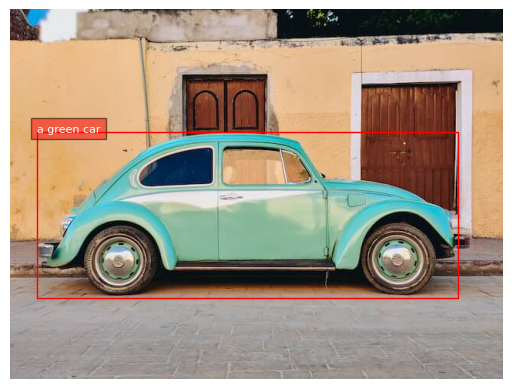

In [61]:
plot_bbox(image, bbox_results)

### region to texts

In [28]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [29]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'turquoise Volkswagen Beetle<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [30]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

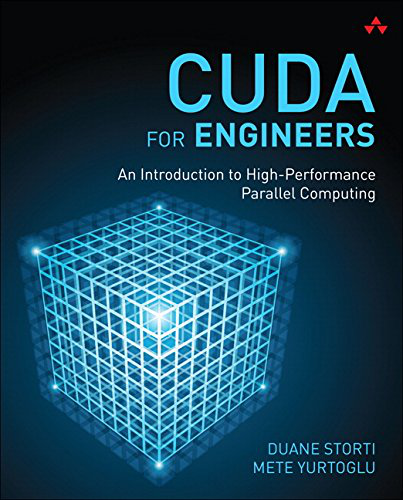

In [31]:
image

In [32]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'CUDA\nFOR ENGINEERS\nAn Introduction to High-Performance\nParallel Computing\nDUANE STORTI\nMETE YURTOGLU\n'}

In [33]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.44650268554688, 50.25, 374.9914855957031, 50.25, 374.9914855957031, 114.25, 167.44650268554688, 114.25], [144.8784942626953, 121.25, 374.9914855957031, 120.25, 374.9914855957031, 149.25, 144.8784942626953, 150.25], [115.86249542236328, 165.25, 375.7974853515625, 165.25, 375.7974853515625, 183.25, 115.86249542236328, 183.25], [239.9864959716797, 184.25, 375.7974853515625, 185.25, 375.7974853515625, 203.25, 239.9864959716797, 201.25], [265.77850341796875, 440.75, 375.7974853515625, 440.75, 375.7974853515625, 456.25, 265.77850341796875, 456.25], [250.86749267578125, 459.25, 375.7974853515625, 459.25, 375.7974853515625, 474.25, 250.86749267578125, 474.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [34]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)

    display(image)

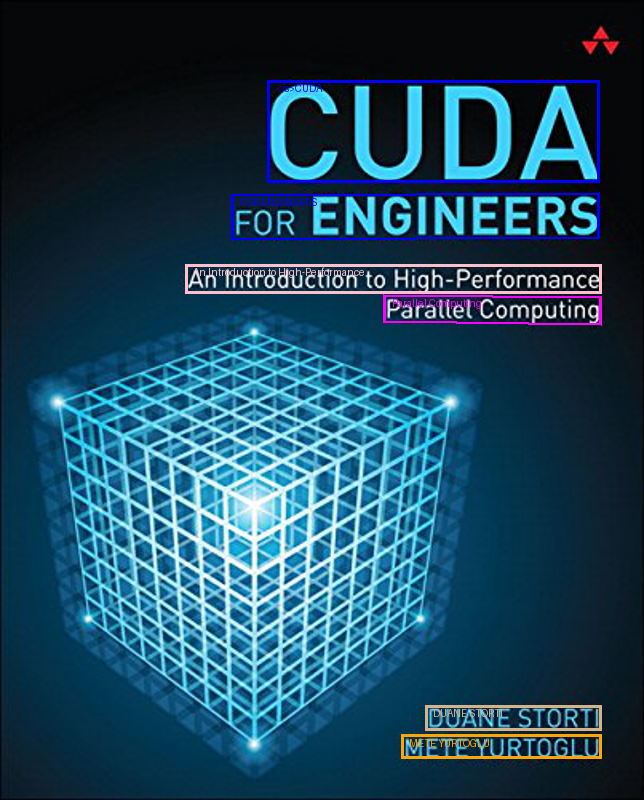

In [35]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)

## Cascaded tasks

### Caption + Phrase Grounding

results format:

{
 '\<CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [36]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [37]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [38]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234,
    159.1199951171875,
    582.0800170898438,
    374.6399841308594],
   [1.5999999046325684,
    4.559999942779541,
    638.3999633789062,
    304.55999755859375]],
  'labels': ['A green car', 'a yellow building']},
 '<CAPTION>': 'A green car parked in front of a yellow building.'}

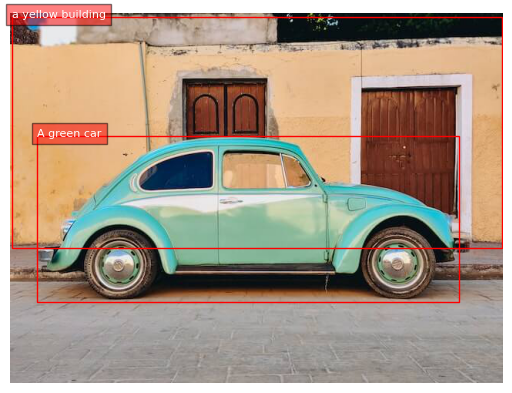

In [39]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding

results format:

{
 '\<DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [40]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [41]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[33.599998474121094,
    159.1199951171875,
    582.0800170898438,
    375.1199951171875],
   [1.5999999046325684, 6.0, 638.3999633789062, 305.5199890136719],
   [452.79998779296875,
    94.31999969482422,
    582.719970703125,
    265.67999267578125],
   [223.0399932861328,
    84.23999786376953,
    335.03997802734375,
    166.8000030517578],
   [344.0, 1.1999999284744263, 638.3999633789062, 40.55999755859375],
   [17.600000381469727,
    1.1999999284744263,
    637.760009765625,
    44.39999771118164],
   [19.520000457763672,
    1.1999999284744263,
    104.63999938964844,
    45.36000061035156]],
  'labels': ['a green Volkswagen Beetle',
   'a yellow building',
   'brown doors',
   'brown doors',
   'trees',
   'a clear blue sky',
   'a clear blue sky']},
 '<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

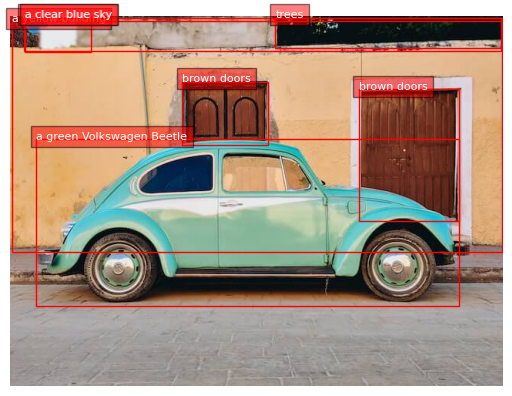

In [42]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding

results format:

{
 '\<MORE_DETAILED_CAPTION': pure_text,
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [43]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [44]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[35.52000045776367,
    158.16000366210938,
    580.1599731445312,
    372.7200012207031],
   [1.5999999046325684,
    340.0799865722656,
    637.760009765625,
    477.8399963378906],
   [454.0799865722656,
    94.31999969482422,
    580.7999877929688,
    262.79998779296875],
   [223.67999267578125,
    84.23999786376953,
    333.7599792480469,
    163.9199981689453],
   [36.79999923706055,
    158.16000366210938,
    579.5199584960938,
    372.239990234375],
   [454.0799865722656,
    94.31999969482422,
    580.1599731445312,
    262.79998779296875],
   [223.67999267578125,
    84.72000122070312,
    333.7599792480469,
    163.9199981689453],
   [454.0799865722656,
    94.31999969482422,
    579.5199584960938,
    262.32000732421875],
   [2.240000009536743,
    4.079999923706055,
    637.1199951171875,
    301.1999816894531],
   [19.520000457763672,
    0.7199999690055847,
    102.72000122070312,
    42.959999084472656],
   [345.919982910

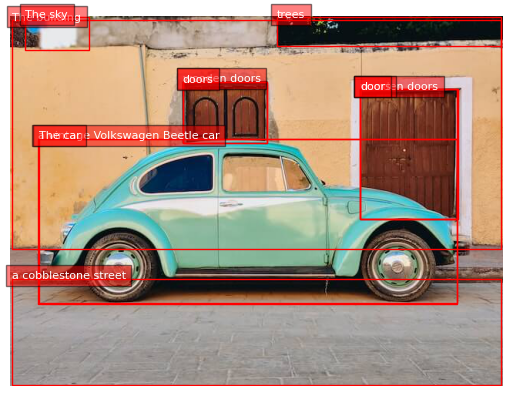

In [45]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])